##  Coursera Capstone Project - IBM Data Science Certificate

This notebook encapsulates the code that works through the analysis of location data to derive some insights into a business issue, as per the requirements of the Capstone Project for IBM Data Science Certification

The Business Issue

This business issue is a hypothetical one as I don't have a real case that fulfills the requirements for the Capstone Projectc i.e. use FourSquare API and data.   This case involves a business with investments in the Food & Beverage / Hospitality sector looking to expand into the Richmond-upon-Thames administration area.  The Richmond-upon-Thames administration area lies within the boundaries of the Greater London are and consists of 19 main neighbourhoods.  This includes famous landmarks such as the Twickenham Rugby Stadium, which is considered the home of rubgy

The business is looking to enter this area by opening another outlet.  The business runs multiple arms in the business, which includes coffee shops, fast food joints, restaurants and wine bars.  As a first step in opening an outlet, the business would like to get an initial understanding of the neighbourhoods and the clustering of food related companies operating in these regions.  This will then feed into further analysis necessary for decision making including socio-economic distributions, footfall patterns, food venues opening/closing data, market gaps.

Assumptions, business logic: The assumption behind the analysis is that we can use unsupervised machine learning to create clusters of districts that will provide us a list of areas for consideration for the restaurant. The intent is the opening will be ideally located in a potentially underserved neighbourhood or one with a gap in offerings (e.g. lack of a high-end burger place).

This notebook addresses this first step in the analysis.

The Data

To do this, we will need the following data:

List of the neighbourhoods in the Richmond admin area -> This will be scraped from the website www.doogal.co.uk
Top venues of neighbourhoods -> Foursquare API is used to collect the venue data

Co-ordinate data is inherent in the data coming from www.doogal.co.uk


Scope, Approach, Assumptions and Limitations

Scope- we will work through all 19 neighbourhoods of the admin area.  In doing this, though there is postcode data that provides greater granularity, for brevity and focus, we will look at the neighbourhood names and group all the subsequent processing on this attribute.  Therefore analysis is performed at the neighbourhood level.

Approach: After tidying up the data, we will apply K-means machine learning technique for creating clusters of the neighbourhoods. We will use silhouette score for choosing the optimal number of clusters.

Assumption:  The data obtained from both data sources is considered complete and accurate.  No separate verification process has been performed.

Limitations: Due to multiple considerations, the data gathering from the FourSquare API is limited to 500m around the co-ordinates being used for each of the neighbourhoods.  An initial limitation on the venues retrieved was set to 50.  However, the results returned were limited so it was decided to increase this number to 100.


### 1. Import Libraries, Retrieve, clean and prepare data

In [1]:
# The first step is to import and install the required libraries

import pandas as pd
from lxml import html
import numpy as np
import requests
from bs4 import BeautifulSoup as bs
import urllib.request, urllib.parse, urllib.error
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
!pip install folium
import folium
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans


With the libraries imported, I now create a DataFrame to collect the data into for subsequent processing. I collect only 4 data items for each neighbourhood.

In [2]:
df_places = pd.DataFrame (columns = ['PCode', 'Area', 'Lat','Long'])

I get the Area names, postcode root (first 4 characters), the latitude and longitude information from www.doogal.co.uk website. The following information is scrapped from the website and added to the initial dataframe.

In [3]:
# The processing loops through 46 pages.  This is hard-coded for this exercise.  In normal business environment processing this would be calculated field.

for x in range (0,46):
    url = 'https://www.doogal.co.uk/AdministrativeAreas.php?district=E09000027&page='+ str(x)
    html = urllib.request.urlopen(url).read()
    soup = bs(html, 'html.parser')
    for tr in soup.find_all('tr')[2:]:
        tds = tr.find_all('td')
        pcode = tds[0].text.split(" ")
        pcodert = pcode[0]
# now create a 'newrow' to ve appended to the data frame 
        newrow = {'PCode': pcodert,'Area': tds[1].text,'Lat':tds[2].text,'Long':tds[3].text}
        df_places = df_places.append(newrow, ignore_index = True)


# Now print the shape of the dataframwe as well as the first 5  rows.

print (df_places.shape)
df_places.head()

(7847, 4)


,PCode,Area,Lat,Long
0,KT1,Hampton Wick,51.412355,-0.31185
1,KT1,Hampton Wick,51.409578,-0.310033
2,KT1,Hampton Wick,51.404226,-0.309936
3,KT1,Hampton Wick,51.399714,-0.314472
4,KT1,Hampton Wick,51.410868,-0.312193


On inspecting the dataframe, we note that there are many duplicates, therefore we remove these duplicates to be bring the neighbourhood addresses to a more manageable size and remove redundant address. Print the shape to compare as well as first few lines of the new dataframe

In [4]:
hn_areas = df_places.drop_duplicates(subset=['PCode', 'Area'], keep='first')

print (hn_areas.shape)
hn_areas.head()

(48, 4)


,PCode,Area,Lat,Long
0,KT1,Hampton Wick,51.412355,-0.31185
18,KT1,Teddington,51.412046,-0.31724
118,KT2,"Ham, Petersham and Richmond Riverside",51.427081,-0.293606
132,KT8,Hampton,51.406791,-0.348605
152,SW13,Mortlake and Barnes Common,51.471836,-0.248994


Now set-up the API parameters (The Client ID and Secret are removed for publihing)

In [5]:
CLIENT_ID = 'CLIENT ID'
CLIENT_SECRET = 'CLIENT SECRET'
VERSION = '20200630'
LIMIT = 100
radius = 500

Setting up a routine that extracts the key venue information.  Though I could have done this in line, I have defined ut as a procedure.

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude',
                  'Neighborhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return(nearby_venues)

I now use the above routine to extract the venue data items by neighbourhood. I also print it to do a visual check on the resultant data

In [7]:
hounslow_venues = getNearbyVenues(names=hn_areas['Area'],
                latitudes=hn_areas['Lat'],
                longitudes=hn_areas['Long']
                                  )
print (hounslow_venues.head())

Hampton Wick
Teddington
Ham, Petersham and Richmond Riverside
Hampton
Mortlake and Barnes Common
Barnes
Ham, Petersham and Richmond Riverside
East Sheen
Mortlake and Barnes Common
North Richmond
Kew
East Sheen
Mortlake and Barnes Common
St Margarets and North Twickenham
Twickenham Riverside
Ham, Petersham and Richmond Riverside
West Twickenham
South Twickenham
Teddington
Kew
North Richmond
South Richmond
Ham, Petersham and Richmond Riverside
East Sheen
Teddington
Hampton Wick
Fulwell and Hampton Hill
South Twickenham
Ham, Petersham and Richmond Riverside
Hampton North
Hampton
Fulwell and Hampton Hill
West Twickenham
South Twickenham
St Margarets and North Twickenham
West Twickenham
Fulwell and Hampton Hill
Heathfield
Whitton
Whitton
Heathfield
Heathfield
St Margarets and North Twickenham
Whitton
South Richmond
North Richmond
Kew
Heathfield
   Neighborhood Neighborhood Latitude Neighborhood Longitude  \
0  Hampton Wick             51.412355               -0.31185   
1  Hampton Wick     

### 2. Prepare the data for K-Clustering Analysis 

Now I execute the One-Hot coding procedure on the above data 

In [8]:
# one hot encoding
hounslow_onehot = pd.get_dummies(hounslow_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hounslow_onehot['Neighborhood'] = hounslow_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [hounslow_onehot.columns[-1]] + list(hounslow_onehot.columns[:-1])
hounslow_onehot = hounslow_onehot[fixed_columns]

print (hounslow_onehot.head())

   Neighborhood  American Restaurant  Argentinian Restaurant  Art Gallery  \
0  Hampton Wick                    0                       0            0   
1  Hampton Wick                    0                       0            0   
2  Hampton Wick                    0                       0            0   
3  Hampton Wick                    0                       0            0   
4  Hampton Wick                    0                       0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   BBQ Joint  Bakery  ...  Tapas Restaurant  Tea Room  Tennis Court  \
0  

In [10]:
hounslow_grouped = hounslow_onehot.groupby('Neighborhood').mean().reset_index()
hounslow_grouped

,Neighborhood,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,...,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Track,Trail,Train Station,Vietnamese Restaurant,Waterfront
0,Barnes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,...,0.000000,0.000000,0.000000,0.038462,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000
1,East Sheen,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Fulwell and Hampton Hill,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Ham, Petersham and Richmond Riverside",0.000000,0.000000,0.016393,0.000000,0.000000,0.016393,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.016393,0.000000,0.016393,0.000000,0.016393,0.000000
4,Hampton,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.071429
5,Hampton North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Hampton Wick,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,...,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000
7,Heathfield,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Kew,0.000000,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.022222,0.022222,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000
9,Mortlake and Barnes Common,0.022727,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.022727,...,0.022727,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.022727


Define a routine to extract the Category for each venue

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now extract the most common venues by neighbourhood.

In [12]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hounslow_grouped['Neighborhood']

for ind in np.arange(hounslow_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hounslow_grouped.iloc[ind, :], num_top_venues)

hounslow_grouped_clustering = hounslow_grouped.drop('Neighborhood', 1)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnes,Food & Drink Shop,Café,Pub,Farmers Market,Park,Lake,Italian Restaurant,Community Center,Movie Theater,Coffee Shop
1,East Sheen,Coffee Shop,Pub,Pizza Place,Stationery Store,Pharmacy,Creperie,Plaza,Dance Studio,Chinese Restaurant,Middle Eastern Restaurant
2,Fulwell and Hampton Hill,Pub,Pizza Place,Convenience Store,Café,Fish & Chips Shop,Seafood Restaurant,Chinese Restaurant,Diner,Garden Center,Fast Food Restaurant
3,"Ham, Petersham and Richmond Riverside",Pub,Coffee Shop,Italian Restaurant,Pharmacy,Indian Restaurant,Park,Grocery Store,Café,Bus Station,Bus Stop
4,Hampton,Park,Grocery Store,Café,Waterfront,Beer Garden,Pizza Place,Pub,Canal Lock,Seafood Restaurant,Soccer Stadium


Set-up a routine to plot a graph using matplotlib

In [13]:

%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()
    
    

Now run the Silhouette scoring and plot on the graph

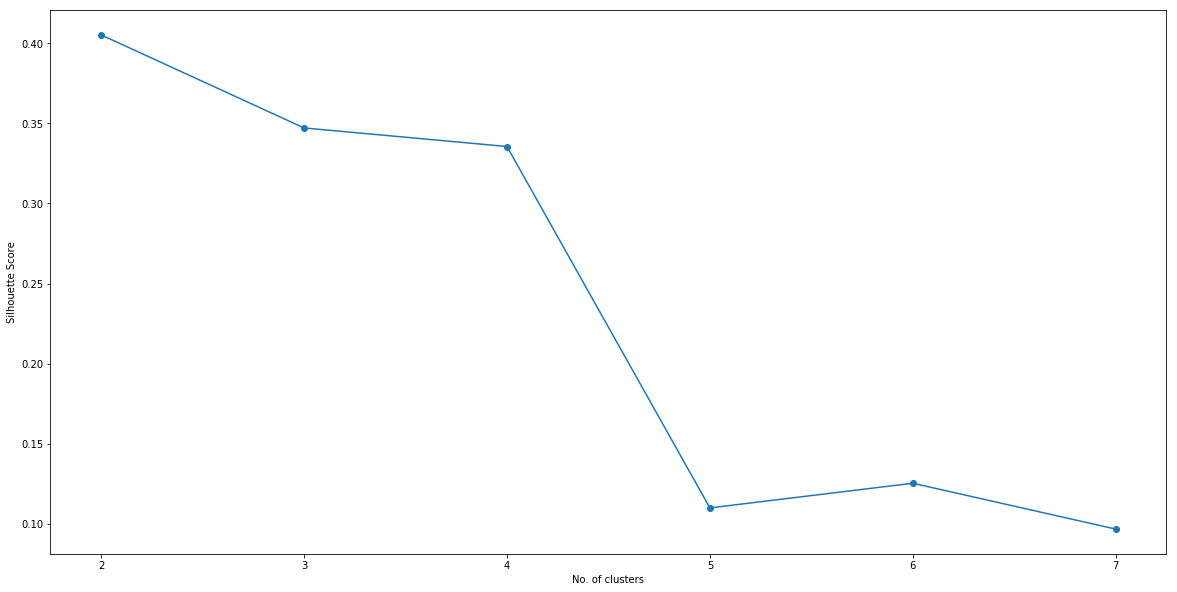

In [14]:
max_range = 8 # Maximum range of clusters
indices = []
scores = []

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = hounslow_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

plot(max_range, scores, "No. of clusters", "Silhouette Score")

### 3.  Run the K-Clustering algorithms 

Based on this graph, we can see that the optimal number of clusters is 5.

Now let's run the K-means clustering with the optimal number of clusters.

In [15]:
# run k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(hounslow_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# Add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [16]:
hn_areas2 = hn_areas.drop_duplicates(subset=['Area'], keep='first')
hn_areas2.drop ('PCode',axis=1, inplace = True)
hn_areas2.rename(columns = {'Area':'Neighborhood'}, inplace = True)
print (hn_areas2)


                               Neighborhood        Lat       Long
0                              Hampton Wick  51.412355   -0.31185
18                               Teddington  51.412046   -0.31724
118   Ham, Petersham and Richmond Riverside  51.427081  -0.293606
132                                 Hampton  51.406791  -0.348605
152              Mortlake and Barnes Common  51.471836  -0.248994
178                                  Barnes  51.472825  -0.241166
779                              East Sheen    51.4614  -0.269921
799                          North Richmond  51.465757  -0.273888
812                                     Kew  51.470998  -0.273734
1441      St Margarets and North Twickenham  51.450115  -0.331333
1618                   Twickenham Riverside  51.454618  -0.311731
2072                        West Twickenham  51.442527  -0.346712
2204                       South Twickenham  51.444999  -0.330793
2762                         South Richmond  51.461474  -0.288445
3627      

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [17]:
hounslow_merged = hn_areas2

# merge hounslow_merged with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
hounslow_merged = hounslow_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
hounslow_merged.dropna(inplace = True)

# add clustering labels
hounslow_merged['Cluster Labels'] = hounslow_merged['Cluster Labels'].astype(int)
hounslow_merged.head()

,Neighborhood,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hampton Wick,51.412355,-0.31185,1,Pub,Park,Coffee Shop,Clothing Store,Department Store,Hotel,Thai Restaurant,Restaurant,Café,Plaza
18,Teddington,51.412046,-0.31724,1,Pub,Coffee Shop,Hotel,Italian Restaurant,Park,Café,Indian Restaurant,Mediterranean Restaurant,Grocery Store,Train Station
118,"Ham, Petersham and Richmond Riverside",51.427081,-0.293606,1,Pub,Coffee Shop,Italian Restaurant,Pharmacy,Indian Restaurant,Park,Grocery Store,Café,Bus Station,Bus Stop
132,Hampton,51.406791,-0.348605,0,Park,Grocery Store,Café,Waterfront,Beer Garden,Pizza Place,Pub,Canal Lock,Seafood Restaurant,Soccer Stadium
152,Mortlake and Barnes Common,51.471836,-0.248994,0,Pub,Park,Grocery Store,Coffee Shop,Farmers Market,Gastropub,Café,Gym / Fitness Center,Platform,Pizza Place


In [18]:
# Create clustering map

hn_lat = 51.4609
hn_lng = -0.3731

# create map
map_clusters = folium.Map(location=[hn_lat, hn_lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hounslow_merged['Lat'], hounslow_merged['Long'], hounslow_merged['Neighborhood'], hounslow_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 4. Analyse the Clusters

#### Cluster 1

In [19]:
hounslow_merged.loc[hounslow_merged['Cluster Labels'] == 0, hounslow_merged.columns[[0] + list(range(4, hounslow_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
132,Hampton,Park,Grocery Store,Café,Waterfront,Beer Garden,Pizza Place,Pub,Canal Lock,Seafood Restaurant,Soccer Stadium
152,Mortlake and Barnes Common,Pub,Park,Grocery Store,Coffee Shop,Farmers Market,Gastropub,Café,Gym / Fitness Center,Platform,Pizza Place
178,Barnes,Food & Drink Shop,Café,Pub,Farmers Market,Park,Lake,Italian Restaurant,Community Center,Movie Theater,Coffee Shop
6119,Whitton,Rugby Stadium,Park,Convenience Store,Construction & Landscaping,Hotel,Sporting Goods Shop,Hotel Bar,Middle Eastern Restaurant,Museum,Gym / Fitness Center


#### Cluster 2 

In [20]:
hounslow_merged.loc[hounslow_merged['Cluster Labels'] == 1, hounslow_merged.columns[[0] + list(range(4, hounslow_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hampton Wick,Pub,Park,Coffee Shop,Clothing Store,Department Store,Hotel,Thai Restaurant,Restaurant,Café,Plaza
18,Teddington,Pub,Coffee Shop,Hotel,Italian Restaurant,Park,Café,Indian Restaurant,Mediterranean Restaurant,Grocery Store,Train Station
118,"Ham, Petersham and Richmond Riverside",Pub,Coffee Shop,Italian Restaurant,Pharmacy,Indian Restaurant,Park,Grocery Store,Café,Bus Station,Bus Stop
779,East Sheen,Coffee Shop,Pub,Pizza Place,Stationery Store,Pharmacy,Creperie,Plaza,Dance Studio,Chinese Restaurant,Middle Eastern Restaurant
799,North Richmond,Coffee Shop,Supermarket,Pub,Food Truck,Seafood Restaurant,Middle Eastern Restaurant,Restaurant,Chinese Restaurant,Stationery Store,Plaza
812,Kew,Garden,Pub,Park,Botanical Garden,Restaurant,Hotel,Gym / Fitness Center,Art Gallery,Pier,Food Stand
1441,St Margarets and North Twickenham,Pub,Coffee Shop,Italian Restaurant,Indian Restaurant,Bus Stop,Pharmacy,Grocery Store,Vietnamese Restaurant,Japanese Restaurant,Farmers Market
2072,West Twickenham,Pub,Bus Stop,Supermarket,Pharmacy,Restaurant,Hardware Store,Health & Beauty Service,Italian Restaurant,Thai Restaurant,Fish & Chips Shop
2204,South Twickenham,Pub,Coffee Shop,Italian Restaurant,Pizza Place,Indian Restaurant,Grocery Store,Café,Supermarket,Convenience Store,Fast Food Restaurant
2762,South Richmond,Pub,Café,Italian Restaurant,Coffee Shop,Bakery,Bar,Restaurant,Train Station,Grocery Store,Burger Joint


#### Cluster 3

In [21]:
hounslow_merged.loc[hounslow_merged['Cluster Labels'] == 2, hounslow_merged.columns[[0] + list(range(4, hounslow_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5857,Heathfield,Playground,Soccer Field,Convenience Store,Park,Café,Chinese Restaurant,Pub,Grocery Store,Furniture / Home Store,Cricket Ground


#### Cluster 4

In [22]:
hounslow_merged.loc[hounslow_merged['Cluster Labels'] == 3, hounslow_merged.columns[[0] + list(range(4, hounslow_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1618,Twickenham Riverside,Thai Restaurant,Café,Pier,Italian Restaurant,Indian Restaurant,Liquor Store,Dance Studio,Cycle Studio,Deli / Bodega,Fish Market


#### Cluster 5

In [24]:
hounslow_merged.loc[hounslow_merged['Cluster Labels'] == 4, hounslow_merged.columns[[0] + list(range(4, hounslow_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4582,Hampton North,Jewelry Store,Gym / Fitness Center,Coffee Shop,Supermarket,Department Store,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Diner


### Conclusion

The conclusion that can be drawn here, for input into the next stage on analysis is as follows:-
    
- If the business wants to place itself in the main areas with a large number of food establishments then it should invest more time exploring Cluster 2.  Neighbourhoods like Fulwell and Hampton Hill or North Richmond offer a GAP IN THE MARKET.  A casual scan suggests a concentration of Italian and Asian restaurants along with some fast food places.  Is there a gap in the market for say something like a South American (say Mexican)  ? Or even further analysis of the Asian restaurants suggests a gap for a Japanese (sushi or izakaya) establishment.  Perhaps somewhere like Fulwell and Hampton Hill or North Richmond 

- if the business is looking to enter undersered areas then CLusters 1 and 3 offer good opportunities.
In Cluster 1,  Whitton looks promising.  It has a nearby Rugby stadium,  a park, a hotel and a museum which suggests footfall.  Yet it only has 1 restaurant.  This presents an underserved area.   In Cluste3 ,  Heathfield has a similar scenario as above.  There is a cricket ground, a soccer field, a park, some stores but only 1 food establishment in the 10 categories.  There seems to be footfall albeit it could be time-based (busy on weekends etc)

Either way this analysis helps management focus in to a selected number of neighbourhoods to further analyse before making a decision.